In [ ]:
import matplotlib.pyplot as plt
import numpy
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [ ]:
# архитектура модели
# гиперпараметры
# загрузчик данных
# формирование батча
# инициализировать модель
# оптимизатор
# функция потерь
# опционально шедулеры
# трейн луп

In [ ]:
# hyperparams
inp_dim = 28 * 28
hidden = 256
out_dim = 10
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}' # 'cuda:0' id GPU
n_epochs = 10
batch_size = 128

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5)),
     ])

# зашружаем тренировочный сет
dataset_train = datasets.MNIST('.', 
                               train=True,            
                               download=True, 
                               transform=transform)

dataset_test = datasets.MNIST('.', 
                              train=False,
                              download=True, 
                              transform=transform)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
dataset_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )

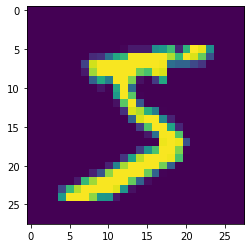

In [ ]:

plt.imshow(dataset_train.data[0].detach().numpy())
plt.show()

In [ ]:
class LinearModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_p=0.1):
        super().__init__()
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        # custom init nn.init.xavier_uniform(self.linear1.weight) 
        self.do = nn.Dropout(dropout_p)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.activ = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activ(x)
        x = self.do(x)
        x = self.linear2(x)

        return x


In [ ]:
# Как формируется батч
# dataloader берет из Samler набор индексов и по этим индексам получает элементы из Dataset
dataset = datasets.MNIST('.', train=True, download=True)

def collate_fn(data: list):
    # data = [(pic, target)...]
    pics = []
    targets = []
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])
    pics = torch.from_numpy(numpy.array(pics)).float() / 255
    pics = pics.view(pics.size(0), -1) # mtx 28x28 to vec 7xx
    targets = torch.from_numpy(numpy.array(targets))

    return {
        'data': pics,
        'target': targets,
    }

In [ ]:
dataloader = DataLoader(dataset, 
                        batch_size, 
                        shuffle=True, 
                        collate_fn=collate_fn,
                        drop_last = True,
                        )

In [ ]:
model = LinearModel(inp_dim, hidden, out_dim).to(device)
model.train() 
optim = torch.optim.Adam(model.parameters())
loss_func = nn.CrossEntropyLoss()


In [ ]:
60000 // 128 # число шагов

468

In [ ]:
for epoch in range(n_epochs):
    
    for i, batch in enumerate(dataloader):
        optim.zero_grad()

        predict = model(batch['data'].to(device))
        loss = loss_func(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
        # TODO Добавить тест модели на тестовом датасете
    #save every epoch
    torch.save(model.state_dict(), f'./chkpt_cv1_{epoch}.pth')

epoch: 0, step: 0, loss: 2.313483715057373
epoch: 0, step: 200, loss: 0.3242669701576233
epoch: 0, step: 400, loss: 0.3634650707244873
epoch: 1, step: 0, loss: 0.2551548480987549
epoch: 1, step: 200, loss: 0.16239196062088013
epoch: 1, step: 400, loss: 0.2046901285648346
epoch: 2, step: 0, loss: 0.06578775495290756
epoch: 2, step: 200, loss: 0.11786012351512909
epoch: 2, step: 400, loss: 0.05996623635292053
epoch: 3, step: 0, loss: 0.16039793193340302
epoch: 3, step: 200, loss: 0.13701295852661133
epoch: 3, step: 400, loss: 0.061461322009563446
epoch: 4, step: 0, loss: 0.05017983168363571
epoch: 4, step: 200, loss: 0.09418758004903793
epoch: 4, step: 400, loss: 0.05416417494416237
epoch: 5, step: 0, loss: 0.0476815328001976
epoch: 5, step: 200, loss: 0.04948681592941284
epoch: 5, step: 400, loss: 0.17958545684814453
epoch: 6, step: 0, loss: 0.14228138327598572
epoch: 6, step: 200, loss: 0.035688366740942
epoch: 6, step: 400, loss: 0.014449234120547771
epoch: 7, step: 0, loss: 0.0432906

# Новый раздел

In [ ]:
# hyperparams
input_ch = 1
hidden_ch = 128
out_dim = 10
device_id = 0
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 10
batch_size = 128

In [ ]:
class ConvDO(nn.Module):
    def __init__(self, input_ch, output_ch, kernel_size, stride, padding, 
                 dropout_p=0.1):
        super().__init__()
        self.conv = nn.Conv2d(
            input_ch, 
            output_ch, 
            kernel_size=kernel_size,
            stride=stride,
            padding=padding, 
        )
        # TODO добавить батч норм
        self.do = nn.Dropout(dropout_p)

    def forward(self, x):

        return self.do(self.conv(x))

class ConvModel(nn.Module):
    def __init__(self, input_ch, hidden_ch, output_dim, dropout_p=0.1):
        super().__init__()
        self.conv1 = ConvDO(input_ch, hidden_ch, 5, 2, 2) # уменьшим размер выходной фичматрицы в 2 раза
        # TODO еще уменьшить размер фичматрицы
        self.conv2 = ConvDO(hidden_ch, hidden_ch, 3, 1, 1)
        # TODO увеличить число выходных каналов
        self.conv3 = ConvDO(hidden_ch, 1, 3, 1, 1)
        self.linear = nn.Linear(
            14 * 14, # TODO поправить при изменении числа каналов и размера фич матриц
            output_dim,
        )  
        self.activ = nn.ReLU()    

    def forward(self, x):
        x = self.activ(self.conv1(x))
        x = self.activ(self.conv2(x))
        x = self.activ(self.conv3(x))
        x = self.linear(x.view(x.size(0), -1))

        return x

In [ ]:
trainloader = torch.utils.data.DataLoader(dataset_train, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

testloader = torch.utils.data.DataLoader(dataset_test, 
                                          batch_size=batch_size,
                                          shuffle=True, 
                                          num_workers=2, 
                                          drop_last = True,)

In [ ]:
model_conv = ConvModel(input_ch, hidden_ch, out_dim).to(device)
optim = torch.optim.Adam(model_conv.parameters())
loss_func = nn.CrossEntropyLoss()

In [ ]:
for epoch in range(n_epochs):
    for i, batch in enumerate(trainloader):
        inputs, labels = batch
        optim.zero_grad()

        predict = model_conv(inputs.to(device))
        loss = loss_func(predict, labels.to(device))
        loss.backward()
        optim.step()
        if i % 200 == 0:
            print(f'epoch: {epoch}, step: {i}, loss: {loss.item()}')
    
    
    model_conv.train()
    # print('test loss:', loss_test / i)
    #save every epoch

    torch.save(model_conv.state_dict(), f'./chkpt_cv1_conv_{epoch}.pth')


epoch: 0, step: 0, loss: 2.304516553878784
epoch: 0, step: 200, loss: 0.2768842875957489
epoch: 0, step: 400, loss: 0.17278222739696503
epoch: 1, step: 0, loss: 0.19757822155952454
epoch: 1, step: 200, loss: 0.20703542232513428
epoch: 1, step: 400, loss: 0.08382124453783035
epoch: 2, step: 0, loss: 0.14820684492588043
epoch: 2, step: 200, loss: 0.07176264375448227
epoch: 2, step: 400, loss: 0.05215040221810341
epoch: 3, step: 0, loss: 0.24708546698093414
epoch: 3, step: 200, loss: 0.12521882355213165
epoch: 3, step: 400, loss: 0.14112865924835205
epoch: 4, step: 0, loss: 0.0868825688958168
epoch: 4, step: 200, loss: 0.11772947013378143
epoch: 4, step: 400, loss: 0.10143598169088364
epoch: 5, step: 0, loss: 0.0878329649567604
epoch: 5, step: 200, loss: 0.03402248024940491
epoch: 5, step: 400, loss: 0.0447169691324234
epoch: 6, step: 0, loss: 0.027766359969973564
epoch: 6, step: 200, loss: 0.06401383131742477
epoch: 6, step: 400, loss: 0.04805348813533783
epoch: 7, step: 0, loss: 0.04005